<div align="center">

# 2025
# Mineria de datos
# Orazi Roberto
## Trabajo practico 3

</div>

## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Importamos dataset

In [2]:
weather='dxWeather.csv'
df_weather_original=pd.read_csv(weather)
df_weather=df_weather_original.copy()
df_weather.columns = df_weather.columns.str.strip()

temp_mean = df_weather['Temperatura'].mean()
humedad_median = df_weather['Humedad'].median()
viento_median = df_weather['VientoVelocidad'].median()
precip_median = df_weather['Precipitation'].median()
presion_mean = df_weather['PresionAtmosferica'].mean()

# Temperatura: -50°C a 50°C
df_weather.loc[(df_weather['Temperatura'] < -50) | (df_weather['Temperatura'] > 50), 'Temperatura'] = temp_mean

# Humedad: 0% a 100%
df_weather.loc[(df_weather['Humedad'] < 0) | (df_weather['Humedad'] > 100), 'Humedad'] = humedad_median

# VientoVelocidad: 0 a 200 km/h
df_weather.loc[(df_weather['VientoVelocidad'] < 0) | (df_weather['VientoVelocidad'] > 200), 'VientoVelocidad'] = viento_median

# Precipitation: 0 a 500mm
df_weather.loc[(df_weather['Precipitation'] < 0) | (df_weather['Precipitation'] > 500), 'Precipitation'] = precip_median

# PresionAtmosferica: 870 a 1084 hPa
df_weather.loc[(df_weather['PresionAtmosferica'] < 870) | (df_weather['PresionAtmosferica'] > 1084), 'PresionAtmosferica'] = presion_mean

X = df_weather.drop('Estacion', axis=1)
y = df_weather['Estacion']

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42, stratify=y
)

df_weather = pd.concat([X_train, y_train], axis=1)

columnas_numericas_weather = df_weather.select_dtypes(include=[np.number]).columns.tolist()
columnas_categoricas_weather = df_weather.select_dtypes(include=['object']).columns.tolist()

df_weather.head()

/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_20084/689948734.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.87234886025768' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_weather.loc[(df_weather['Temperatura'] < -50) | (df_weather['Temperatura'] > 50), 'Temperatura'] = temp_mean


,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
6206,-13.0,65,10.5,62,873.600000,Costa,Nevado,Otonio
203,1.0,52,13.5,18,1007.685836,Costa,Nublado,Primavera
6711,29.0,50,10.5,12,1013.950000,Montania,Nublado,Primavera
5850,14.0,68,10.5,85,1005.130000,Montania,Lluvioso,Verano
8051,0.0,89,6.5,98,996.480000,Llanura,Nevado,Invierno


Filtramos los valores del dataset entre valores reales ya que hay muchos valores irreales, a los valores irreales los asignamos como nan y los imputamos con valores de la media y mediana dependiendo de la distribucion de cada uno

ANÁLISIS DE DISTRIBUCIÓN POR ESTACIÓN
Distribución absoluta:
Estacion
Invierno     2500
Otonio       2500
Primavera    2598
Verano       2492
Name: count, dtype: int64

Distribución porcentual:
Estacion
Invierno     24.78
Otonio       24.78
Primavera    25.75
Verano       24.70
Name: proportion, dtype: float64


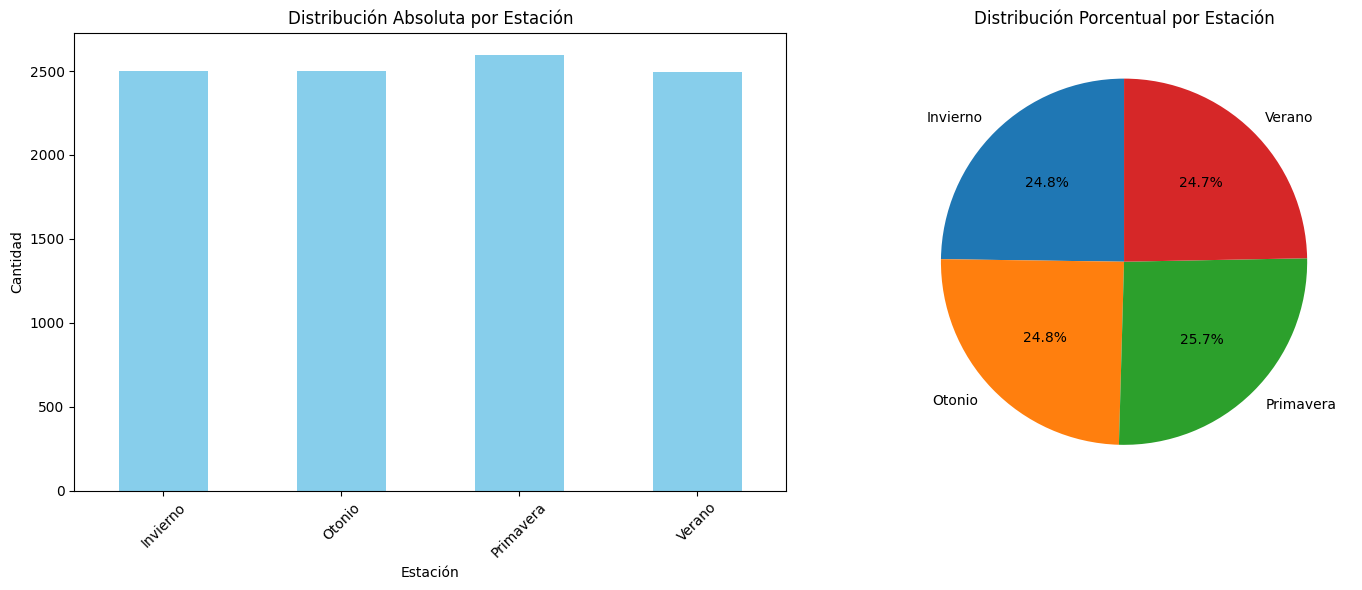


Análisis de balance:
Total de muestras: 10090
Número de clases: 4
Muestras esperadas por clase (balanceado perfecto): 2522.5

Desviación del balance perfecto:
Invierno: 2500 muestras (desviación: 0.9%)
Otonio: 2500 muestras (desviación: 0.9%)
Primavera: 2598 muestras (desviación: 3.0%)
Verano: 2492 muestras (desviación: 1.2%)

Ratio de balance (min/max): 0.959
Dataset BALANCEADO ✅


In [3]:
# Análisis de distribución por estación
print("="*50)
print("ANÁLISIS DE DISTRIBUCIÓN POR ESTACIÓN")
print("="*50)

# Conteo absoluto
print("Distribución absoluta:")
estacion_counts = df_weather_original['Estacion'].value_counts().sort_index()
print(estacion_counts)

# Distribución porcentual
print("\nDistribución porcentual:")
estacion_percent = df_weather_original['Estacion'].value_counts(normalize=True).sort_index() * 100
print(estacion_percent.round(2))

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
estacion_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Distribución Absoluta por Estación')
ax1.set_xlabel('Estación')
ax1.set_ylabel('Cantidad')
ax1.tick_params(axis='x', rotation=45)

# Gráfico de torta
ax2.pie(estacion_counts.values, labels=estacion_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribución Porcentual por Estación')

plt.tight_layout()
plt.show()

# Determinar si está balanceado
total_samples = len(df_weather_original)
expected_per_class = total_samples / len(estacion_counts)
print(f"\nAnálisis de balance:")
print(f"Total de muestras: {total_samples}")
print(f"Número de clases: {len(estacion_counts)}")
print(f"Muestras esperadas por clase (balanceado perfecto): {expected_per_class:.1f}")

print(f"\nDesviación del balance perfecto:")
for estacion, count in estacion_counts.items():
   deviation = abs(count - expected_per_class)
   percentage_dev = (deviation / expected_per_class) * 100
   print(f"{estacion}: {count} muestras (desviación: {percentage_dev:.1f}%)")

# Conclusión
max_count = estacion_counts.max()
min_count = estacion_counts.min()
balance_ratio = min_count / max_count

print(f"\nRatio de balance (min/max): {balance_ratio:.3f}")
if balance_ratio >= 0.8:
   print("Dataset BALANCEADO ✅")
elif balance_ratio >= 0.6:
   print("Dataset MODERADAMENTE DESBALANCEADO ⚠️")
else:
   print("Dataset FUERTEMENTE DESBALANCEADO ❌")

In [4]:
duplicados = df_weather.duplicated().sum()
print(f"Filas duplicadas: {duplicados}")

print("Valores nulos por columna:")
print(df_weather.isnull().sum())

Filas duplicadas: 0
Valores nulos por columna:
Temperatura           0
Humedad               0
VientoVelocidad       0
Precipitation         0
PresionAtmosferica    0
Localizacion          0
TipoClima             0
Estacion              0
dtype: int64


Podemos ver que no tenemos ningun valor nulo ni duplicado, por ende vamos a verificar el tema de los outliers

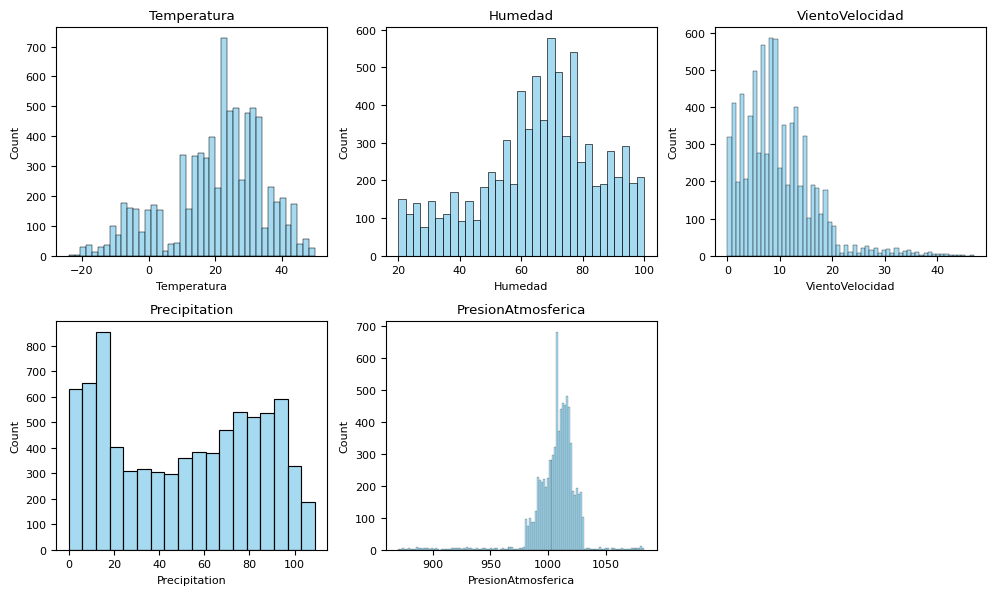

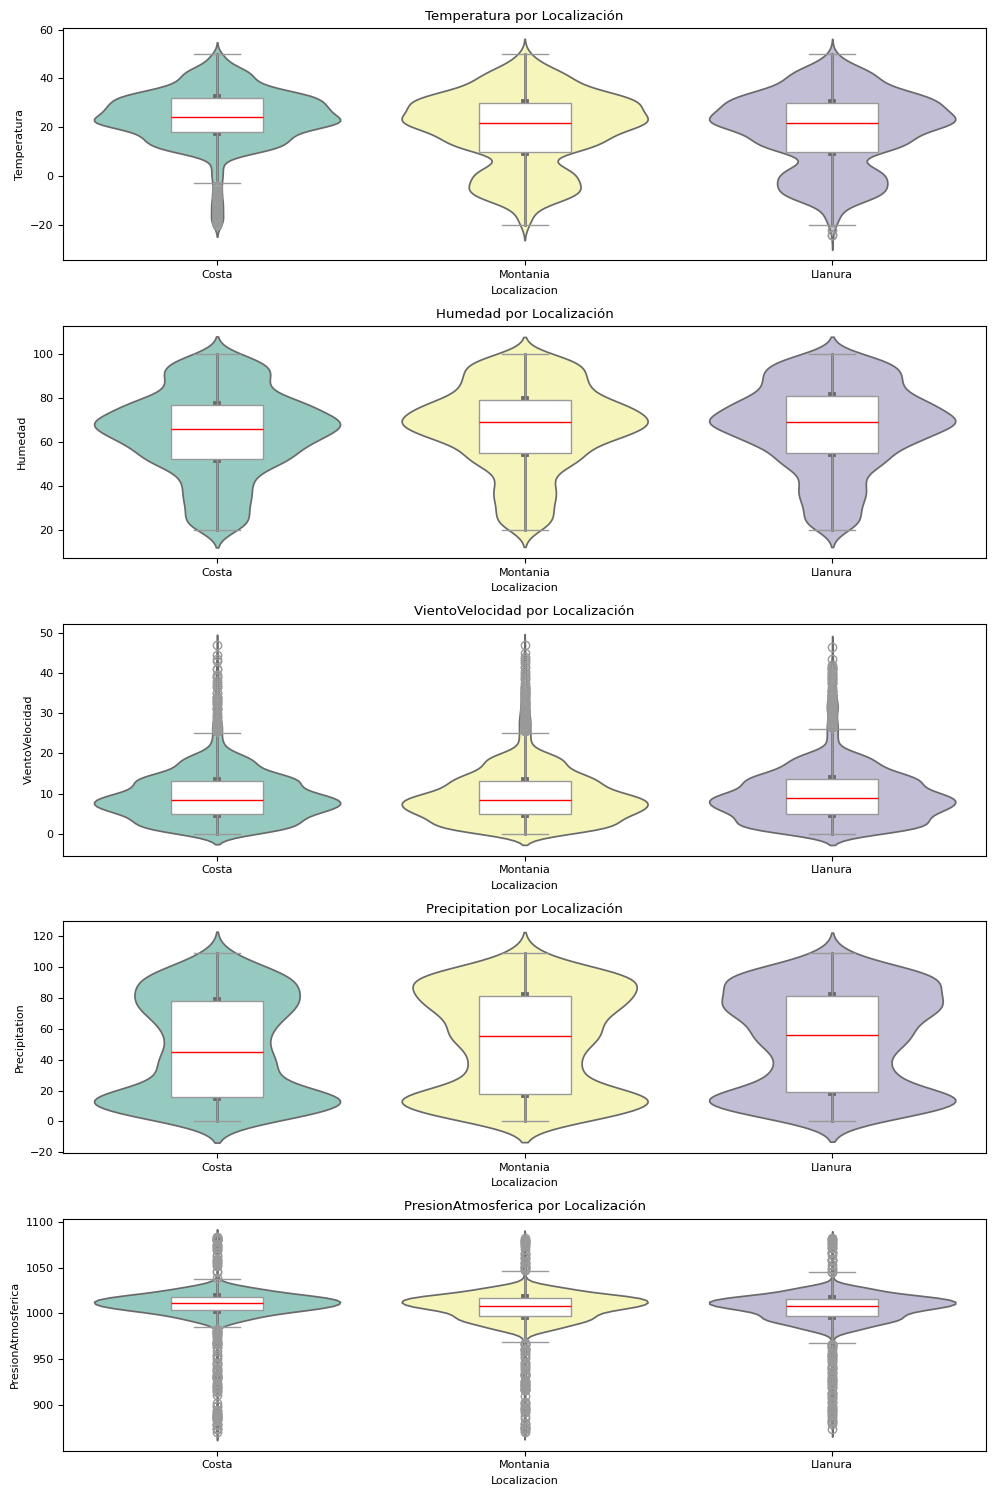

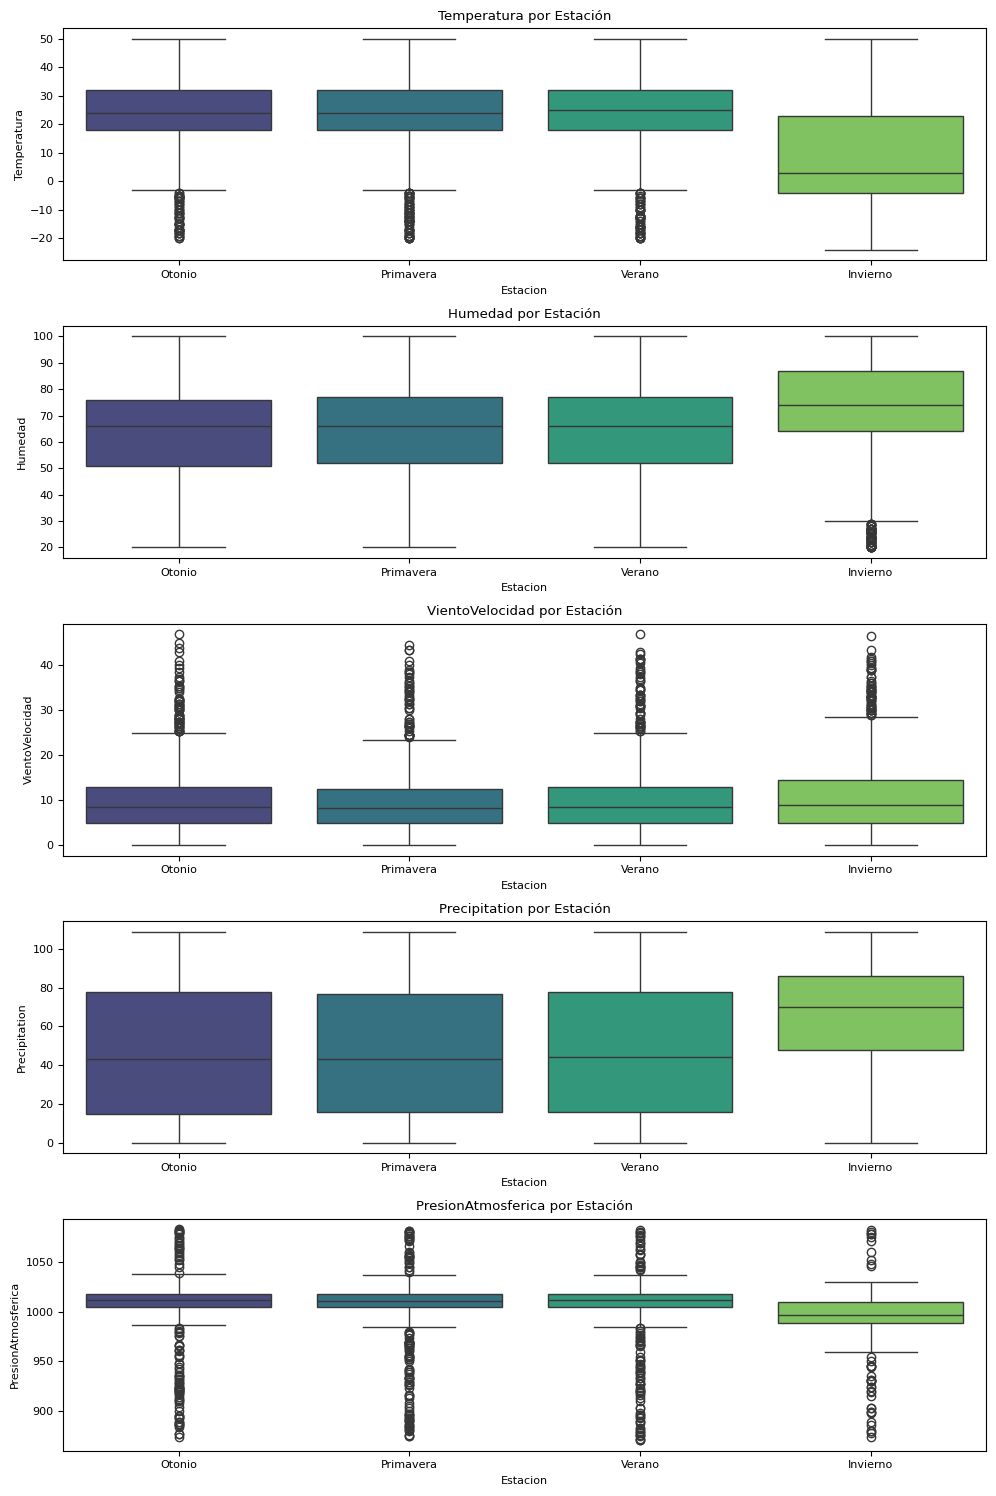

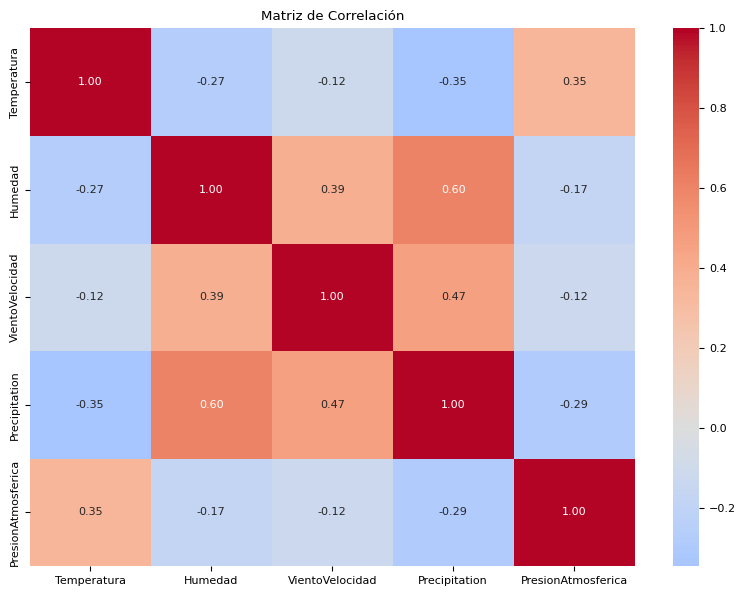

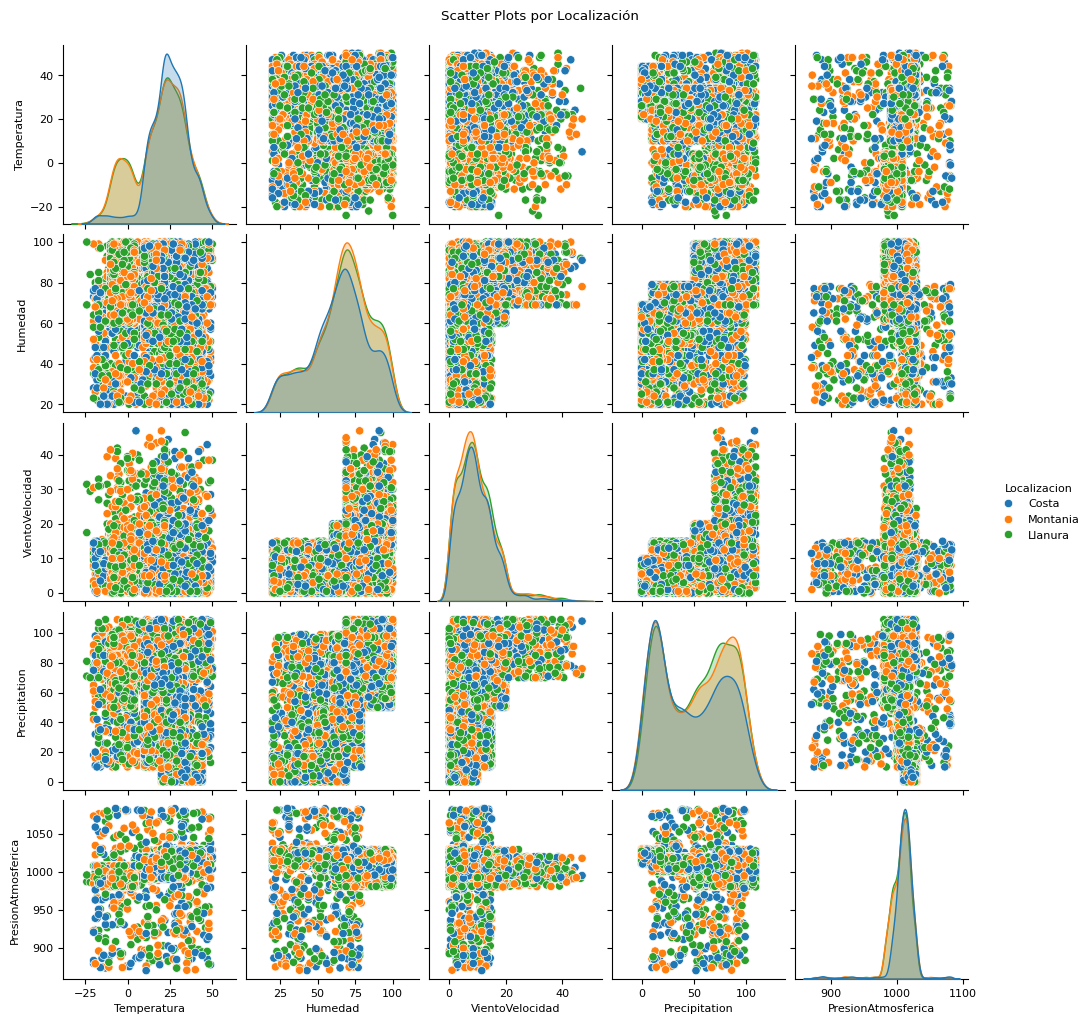

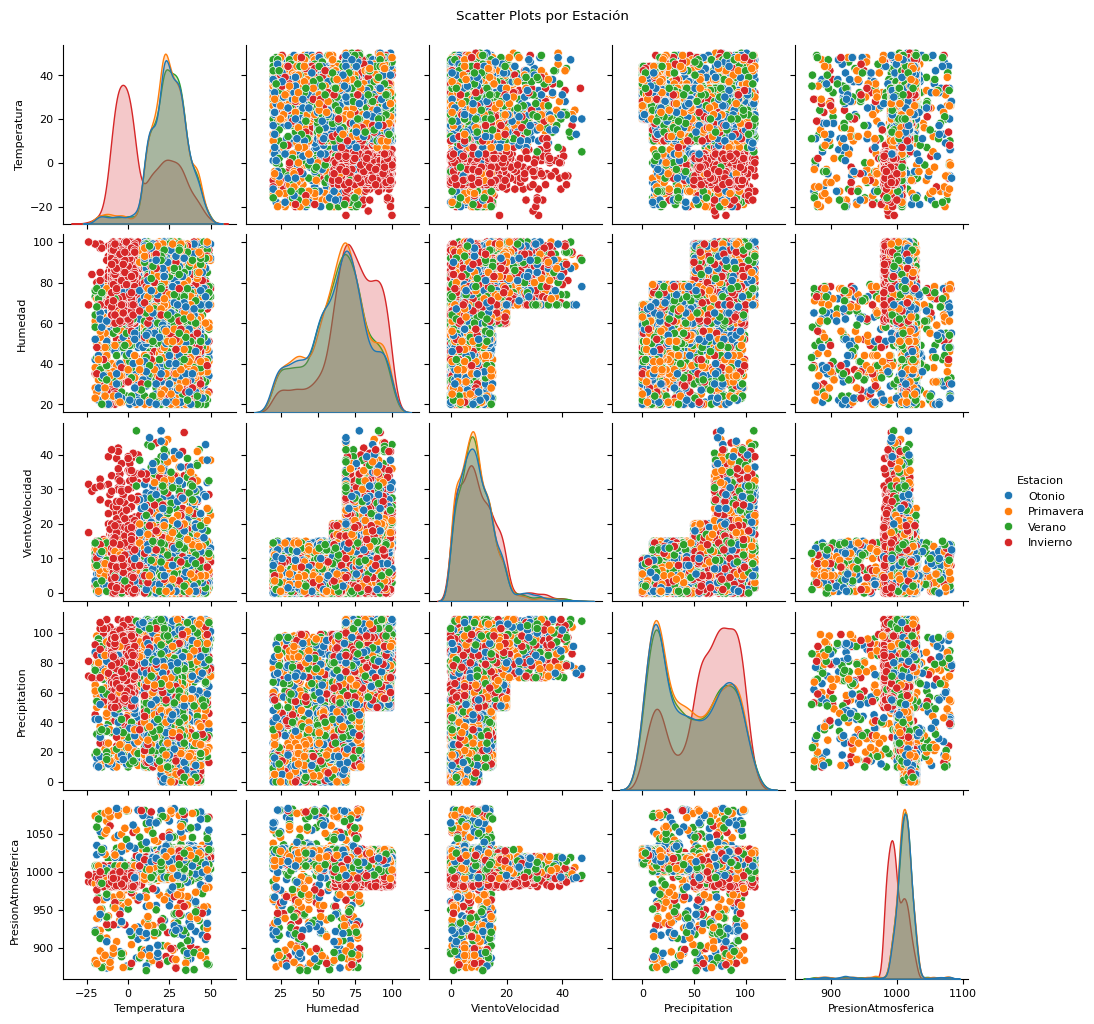

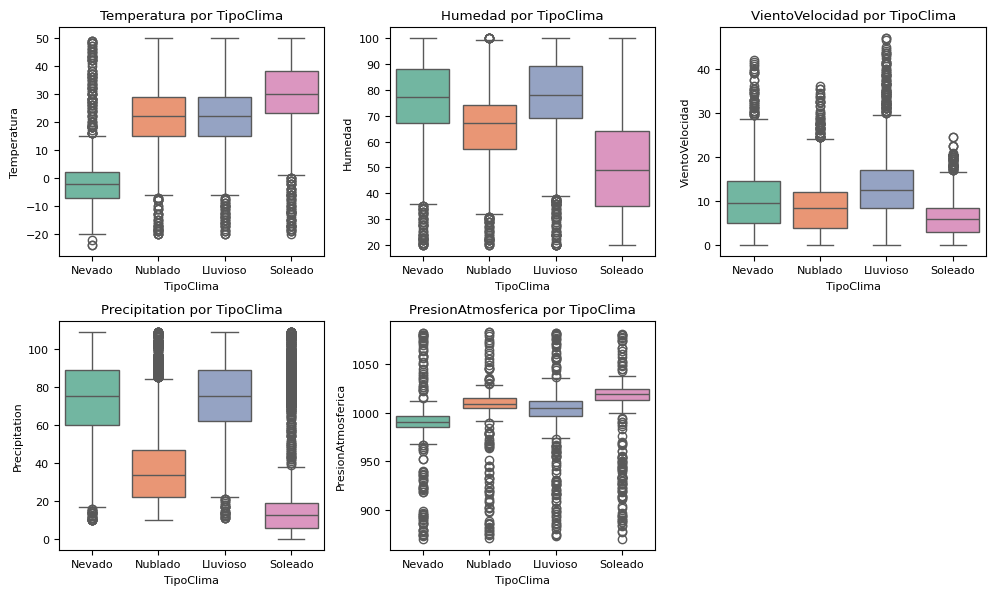

Estadísticas descriptivas por Estación:
          Temperatura                                                      \
                count       mean        std   min   25%   50%   75%   max   
Estacion                                                                    
Invierno       2000.0   9.446149  16.195839 -24.0  -4.0   3.0  23.0  50.0   
Otonio         2000.0  24.112585  11.327765 -20.0  18.0  24.0  32.0  50.0   
Primavera      2078.0  24.009830  11.699070 -20.0  18.0  24.0  32.0  50.0   
Verano         1994.0  24.265830  11.520112 -20.0  18.0  25.0  32.0  50.0   

          Humedad             ... Precipitation        PresionAtmosferica  \
            count       mean  ...           75%    max              count   
Estacion                      ...                                           
Invierno   2000.0  72.654500  ...          86.0  109.0             2000.0   
Otonio     2000.0  63.227000  ...          78.0  109.0             2000.0   
Primavera  2078.0  63.849374  ...  

In [5]:
# Configuración básica
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 8

# 1. Histogramas
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(columnas_numericas_weather):
   if i < len(axes):
       sns.histplot(data=df_weather, x=col, ax=axes[i], color='skyblue')
       axes[i].set_title(f'{col}')

for j in range(i+1, len(axes)):
   axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 2. Violin + boxplot por Localización
fig, axes = plt.subplots(len(columnas_numericas_weather), 1, figsize=(10, 3*len(columnas_numericas_weather)))

if len(columnas_numericas_weather) == 1:
   axes = [axes]

for i, col in enumerate(columnas_numericas_weather):
   sns.violinplot(x='Localizacion', y=col, data=df_weather, ax=axes[i],
                 hue='Localizacion', palette='Set3', legend=False)
   sns.boxplot(x='Localizacion', y=col, data=df_weather, ax=axes[i], 
              color='white', width=0.3, medianprops={'color': 'red'})
   axes[i].set_title(f'{col} por Localización')

plt.tight_layout()
plt.show()

# 3. Boxplots por Estación
fig, axes = plt.subplots(len(columnas_numericas_weather), 1, figsize=(10, 3*len(columnas_numericas_weather)))

if len(columnas_numericas_weather) == 1:
   axes = [axes]

for i, col in enumerate(columnas_numericas_weather):
   sns.boxplot(x='Estacion', y=col, data=df_weather, ax=axes[i], 
              hue='Estacion', palette='viridis', legend=False)
   axes[i].set_title(f'{col} por Estación')

plt.tight_layout()
plt.show()

# 4. Matriz de correlación
plt.figure(figsize=(8, 6))
correlation_matrix = df_weather[columnas_numericas_weather].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

# 5. Pairplot por Localización
sns.pairplot(df_weather[columnas_numericas_weather + ['Localizacion']], 
           hue='Localizacion', height=2)
plt.suptitle('Scatter Plots por Localización', y=1.02)
plt.show()

# 6. Pairplot por Estación
sns.pairplot(df_weather[columnas_numericas_weather + ['Estacion']], 
           hue='Estacion', height=2)
plt.suptitle('Scatter Plots por Estación', y=1.02)
plt.show()

# 7. Análisis TipoClima
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(columnas_numericas_weather):
   if i < len(axes):
       sns.boxplot(x='TipoClima', y=col, data=df_weather, ax=axes[i],
                  hue='TipoClima', palette='Set2', legend=False)
       axes[i].set_title(f'{col} por TipoClima')

for j in range(i+1, len(axes)):
   axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 8. Estadísticas por Estación
print("Estadísticas descriptivas por Estación:")
print(df_weather.groupby('Estacion')[columnas_numericas_weather].describe())

# 9. Conteos
print("\nConteo por categorías:")
print("Estaciones:", df_weather['Estacion'].value_counts())
print("\nLocalizaciones:", df_weather['Localizacion'].value_counts())
print("\nTipo de Clima:", df_weather['TipoClima'].value_counts())

**Resumen del EDA:**

**Distribuciones generales:**
- Temperatura: normal ~25°C, invierno claramente diferente (~10°C)
- Humedad: amplia distribución 20-100%, invierno más húmedo
- Viento: concentrado en valores bajos 0-15 km/h
- Precipitación: bimodal, alta variabilidad
- Presión: normal estrecha ~1000 hPa, consistente entre estaciones

**Separabilidad por estación (target):**
- **Invierno:** fácilmente distinguible (temp baja, humedad alta)
- **Otras 3 estaciones:** más similares entre sí, requieren múltiples variables para separar

**Correlaciones relevantes:**
- Humedad-Precipitación: 0.60 (moderada)
- Resto: correlaciones débiles (-0.35 a 0.47)

**Balance del dataset:**
- **Estaciones:** bien balanceado (~2000-2080 cada una) ✅
- **Localización:** balanceado (2452-2801)
- **TipoClima:** desbalanceado (Nevado: 1291 vs otros: ~2200-2315) ⚠️

**Insights para clasificación:**
1. Temperatura e humedad son las variables más discriminativas
2. Invierno será fácil de clasificar
3. Desafío principal: separar otoño/primavera/verano
4. Outliers significativos en presión atmosférica
5. Variables categóricas (Localización, TipoClima) aportan información adicional

DETECCIÓN DE OUTLIERS (Método IQR):

Temperatura:
  Número de outliers: 97
  Porcentaje: 1.20%
  Rango válido: [-14.00, 58.00]

Humedad:
  Número de outliers: 0
  Porcentaje: 0.00%
  Rango válido: [16.50, 116.50]

VientoVelocidad:
  Número de outliers: 257
  Porcentaje: 3.18%
  Rango válido: [-7.00, 25.00]

Precipitation:
  Número de outliers: 0
  Porcentaje: 0.00%
  Rango válido: [-75.00, 173.00]

PresionAtmosferica:
  Número de outliers: 314
  Porcentaje: 3.89%
  Rango válido: [974.28, 1042.36]

RESUMEN TOTAL:
Total de filas: 8072

Outliers por variable:
  Temperatura: 97 outliers (1.2%)
  Humedad: 0 outliers (0.0%)
  VientoVelocidad: 257 outliers (3.2%)
  Precipitation: 0 outliers (0.0%)
  PresionAtmosferica: 314 outliers (3.9%)


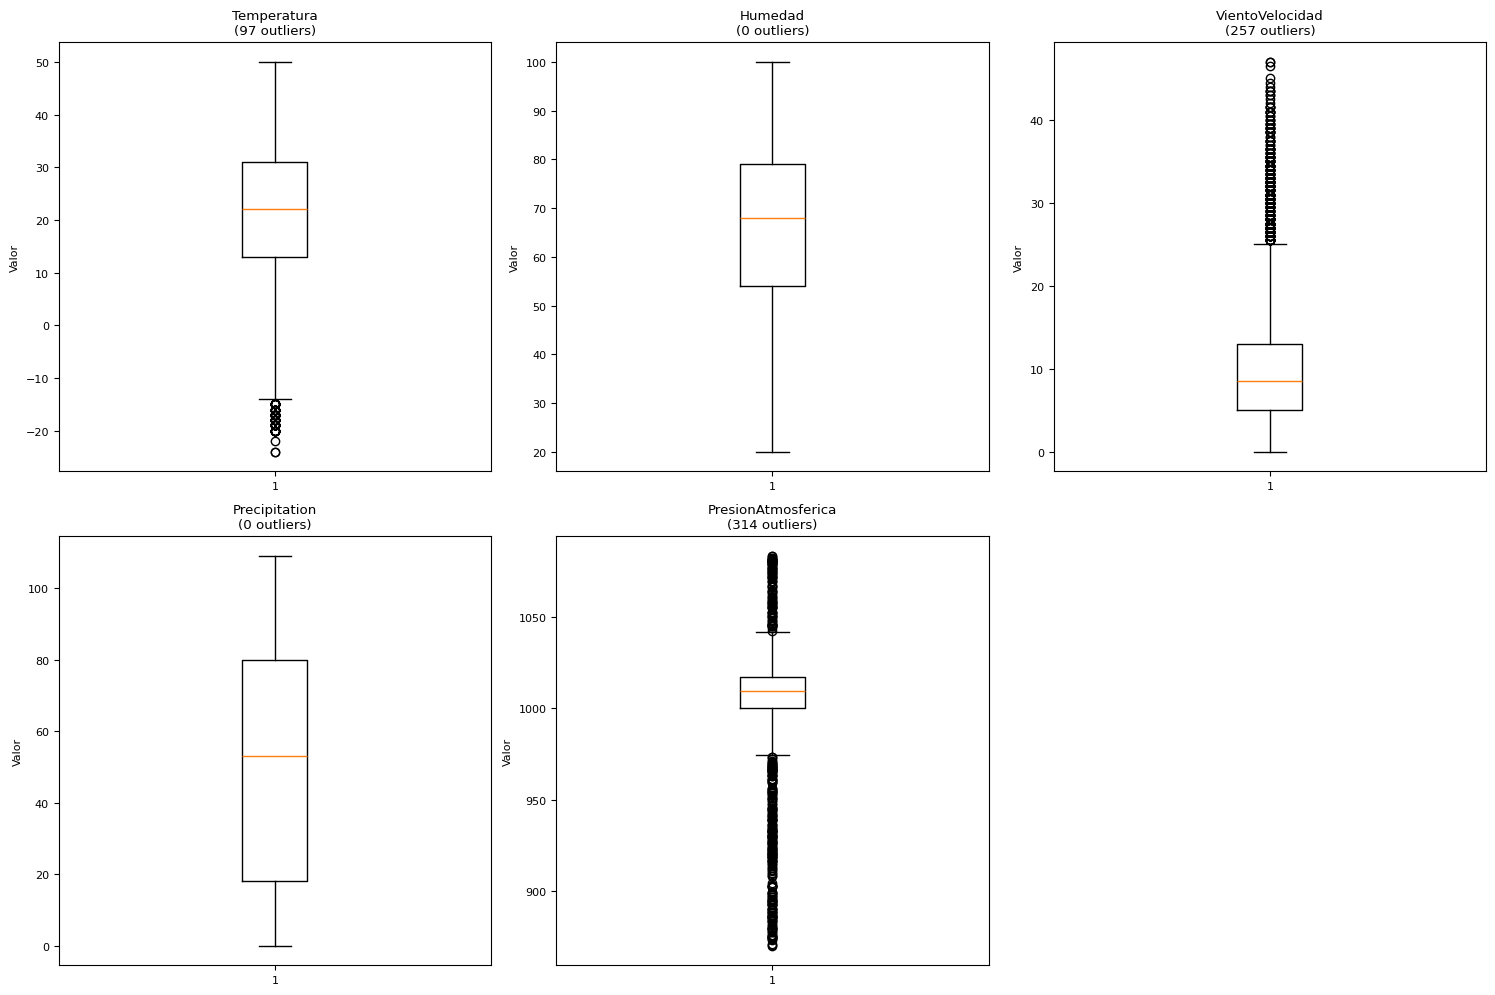


Filas con outliers en múltiples variables: 36

Distribución de outliers por fila:
0    7440
1     596
2      36
Name: count, dtype: int64


In [6]:
# Función para detectar outliers usando el método IQR
def detect_outliers_iqr(df, column):
   Q1 = df[column].quantile(0.25)
   Q3 = df[column].quantile(0.75)
   IQR = Q3 - Q1
   lower_bound = Q1 - 1.5 * IQR
   upper_bound = Q3 + 1.5 * IQR

   # Encontrar outliers
   outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
   return outliers, lower_bound, upper_bound

# Analizar outliers para cada columna numérica
print("DETECCIÓN DE OUTLIERS (Método IQR):")
print("="*50)

# Columnas numéricas específicas del dataset meteorológico
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

outlier_summary = {}
for column in columnas_numericas:
   outliers, lower, upper = detect_outliers_iqr(df_weather, column)
   n_outliers = len(outliers)
   percentage = (n_outliers / len(df_weather)) * 100

   outlier_summary[column] = {
       'count': n_outliers,
       'percentage': percentage,
       'lower_bound': lower,
       'upper_bound': upper
   }

   print(f"\n{column}:")
   print(f"  Número de outliers: {n_outliers}")
   print(f"  Porcentaje: {percentage:.2f}%")
   print(f"  Rango válido: [{lower:.2f}, {upper:.2f}]")

# Resumen total
print("\n" + "="*50)
print("RESUMEN TOTAL:")
total_filas = len(df_weather)
print(f"Total de filas: {total_filas}")
print("\nOutliers por variable:")
for col, info in outlier_summary.items():
   print(f"  {col}: {info['count']} outliers ({info['percentage']:.1f}%)")

# Visualizar outliers con boxplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(columnas_numericas, 1):
   plt.subplot(2, 3, i)
   plt.boxplot(df_weather[column])
   plt.title(f'{column}\n({outlier_summary[column]["count"]} outliers)')
   plt.ylabel('Valor')

plt.tight_layout()
plt.show()

# Identificar filas con múltiples outliers
outlier_masks = {}
for column in columnas_numericas:
   outliers, lower, upper = detect_outliers_iqr(df_weather, column)
   outlier_masks[column] = df_weather.index.isin(outliers.index)

# Contar cuántos outliers tiene cada fila
outlier_count_per_row = pd.DataFrame(outlier_masks).sum(axis=1)
rows_with_multiple_outliers = outlier_count_per_row[outlier_count_per_row > 1]

print(f"\nFilas con outliers en múltiples variables: {len(rows_with_multiple_outliers)}")
if len(rows_with_multiple_outliers) > 0:
   print("\nDistribución de outliers por fila:")
   print(outlier_count_per_row.value_counts().sort_index())

**Análisis de Outliers**

El análisis detectó outliers en Temperatura (97 casos, 1.2%), VientoVelocidad (257 casos, 3.2%) y PresionAtmosferica (314 casos, 3.9%). Estos valores representan condiciones meteorológicas extremas pero reales: temperaturas muy bajas en invierno, vientos fuertes durante tormentas, y fluctuaciones de presión atmosférica.

Se decidió mantener estos outliers porque son fenómenos naturales válidos que aportan información valiosa para clasificar estaciones. Las temperaturas extremas, por ejemplo, son características distintivas del invierno. La baja proporción de outliers (< 4%) indica buena calidad del dataset manteniendo la variabilidad climática natural.

In [7]:
# Encoding variables categóricas en train
le_localizacion = LabelEncoder()
le_tipo_clima = LabelEncoder()

X_train['Localizacion_encoded'] = le_localizacion.fit_transform(X_train['Localizacion'])
X_train['TipoClima_encoded'] = le_tipo_clima.fit_transform(X_train['TipoClima'])

# Aplicar encoding a test (solo transform)
X_test['Localizacion_encoded'] = le_localizacion.transform(X_test['Localizacion'])
X_test['TipoClima_encoded'] = le_tipo_clima.transform(X_test['TipoClima'])

# Eliminar columnas originales
X_train = X_train.drop(['Localizacion', 'TipoClima'], axis=1)
X_test = X_test.drop(['Localizacion', 'TipoClima'], axis=1)

# Estandarizar features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Shape train:", X_train_scaled.shape)
print("Shape test:", X_test_scaled.shape)
print("Columnas:", X_train_scaled.columns.tolist())

Shape train: (8072, 7)
Shape test: (2018, 7)
Columnas: ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica', 'Localizacion_encoded', 'TipoClima_encoded']


## Ejercicio 2
### Prediccion usando maquina de vectores

Resultados Validación Cruzada (k=5):
       C  Accuracy  Precision  Recall
0    0.1    0.3762     0.3755  0.3730
1    1.0    0.3759     0.3748  0.3729
2   10.0    0.3744     0.3751  0.3715
3  100.0    0.3750     0.3729  0.3721

Resultados en test (C=0.1):
              precision    recall  f1-score   support

    Invierno       0.71      0.57      0.63       500
      Otonio       0.28      0.07      0.11       500
   Primavera       0.30      0.86      0.44       520
      Verano       1.00      0.00      0.00       498

    accuracy                           0.38      2018
   macro avg       0.57      0.37      0.30      2018
weighted avg       0.57      0.38      0.30      2018



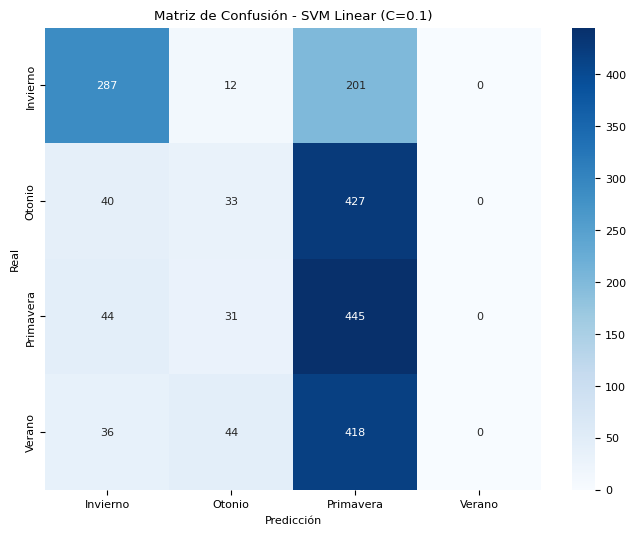

In [8]:
# Definir rango de parámetros C más razonable
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

C_values = [0.1, 1, 10, 100]

results = []

for C in C_values:
    svm_model = SVC(kernel='linear', C=C, random_state=42)

    cv_scores = cross_validate(svm_model, X_train_scaled, y_train,
                              cv=5,
                              scoring=['accuracy', 'precision_macro', 'recall_macro'],
                              return_train_score=False)

    results.append({
        'C': C,
        'Accuracy': cv_scores['test_accuracy'].mean(),
        'Precision': cv_scores['test_precision_macro'].mean(),
        'Recall': cv_scores['test_recall_macro'].mean()
    })

results_df = pd.DataFrame(results)
print("Resultados Validación Cruzada (k=5):")
print(results_df.round(4))

# Modelo final
best_C = results_df.loc[results_df['Accuracy'].idxmax(), 'C']
final_svm = SVC(kernel='linear', C=best_C, random_state=42)
final_svm.fit(X_train_scaled, y_train)
y_pred = final_svm.predict(X_test_scaled)

print(f"\nResultados en test (C={best_C}):")
print(classification_report(y_test, y_pred, zero_division=1))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=sorted(y.unique()),
           yticklabels=sorted(y.unique()))
plt.title(f'Matriz de Confusión - SVM Linear (C={best_C})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Se implementó un clasificador SVM con kernel lineal optimizando el parámetro de regularización C mediante validación cruzada k=5. Se evaluaron valores C = [0.1, 1, 10, 100], siendo C=0.1 el óptimo con accuracy de 37.6%.

**Resultados:**
- **Accuracy global:** 38% - rendimiento bajo para clasificación multiclase
- **Mejor clase:** Verano (precision=1.0, recall=0.0) - sobreajustado sin predicciones
- **Peor clases:** Otoño y Primavera (precision ~0.28-0.30) - alta confusión entre estaciones similares

**Matriz de Confusión:**
- **Invierno:** Clasificación moderada (287/500 correctas) con confusión hacia Primavera
- **Otoño/Primavera/Verano:** Alta confusión mutua - el modelo no logra distinguir efectivamente entre estas estaciones
- **Patrón:** El kernel lineal es insuficiente para capturar las relaciones no lineales entre variables meteorológicas

**Conclusión:**
El SVM lineal muestra limitaciones significativas para este problema multiclase. La baja accuracy (38%) indica que las fronteras lineales no pueden separar adecuadamente las estaciones climáticas, sugiriendo la necesidad de kernels no lineales o modelos más complejos.

## Ejercicio 3
### Prediccion del atributo Estación usando maquina de vectores con kernel gaussiano

Mejores parámetros encontrados:
C = 10.0, gamma = 0.1
Accuracy CV: 0.3899
Precision CV: 0.4580
Recall CV: 0.3891

Resultados en conjunto de test:
C=10.0, gamma=0.1
              precision    recall  f1-score   support

    Invierno       0.97      0.55      0.70       500
      Otonio       0.28      0.29      0.28       500
   Primavera       0.30      0.47      0.36       520
      Verano       0.31      0.25      0.27       498

    accuracy                           0.39      2018
   macro avg       0.46      0.39      0.40      2018
weighted avg       0.46      0.39      0.40      2018


Top 10 mejores combinaciones de parámetros:
        C  gamma  Accuracy  Precision  Recall
10   10.0   0.10    0.3899     0.4580  0.3891
6     1.0   0.10    0.3888     0.4615  0.3876
3     0.1   1.00    0.3874     0.5064  0.3817
2     0.1   0.10    0.3871     0.4225  0.3823
13  100.0   0.01    0.3866     0.4493  0.3849
14  100.0   0.10    0.3863     0.4406  0.3860
7     1.0   1.00    0.3860     0.4

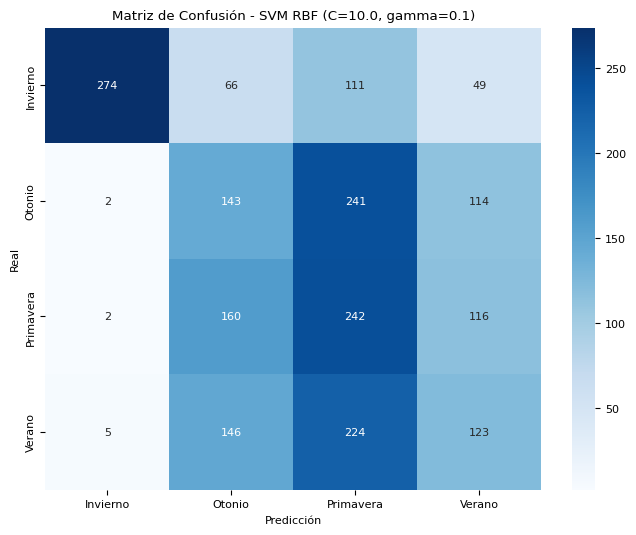

In [9]:
# Parámetros para optimizar
C_values = [0.1, 1, 10, 100]
gamma_values = [0.001, 0.01, 0.1, 1]

results_rbf = []

for C in C_values:
    for gamma in gamma_values:
        svm_rbf = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)

        cv_scores = cross_validate(svm_rbf, X_train_scaled, y_train,
                                  cv=5,
                                  scoring=['accuracy', 'precision_macro', 'recall_macro'],
                                  return_train_score=False)

        results_rbf.append({
            'C': C,
            'gamma': gamma,
            'Accuracy': cv_scores['test_accuracy'].mean(),
            'Precision': cv_scores['test_precision_macro'].mean(),
            'Recall': cv_scores['test_recall_macro'].mean()
        })

results_rbf_df = pd.DataFrame(results_rbf)

# Encontrar mejores parámetros
best_idx = results_rbf_df['Accuracy'].idxmax()
best_params = results_rbf_df.loc[best_idx]

print("Mejores parámetros encontrados:")
print(f"C = {best_params['C']}, gamma = {best_params['gamma']}")
print(f"Accuracy CV: {best_params['Accuracy']:.4f}")
print(f"Precision CV: {best_params['Precision']:.4f}")
print(f"Recall CV: {best_params['Recall']:.4f}")

# Entrenar modelo final con mejores parámetros
final_svm_rbf = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], random_state=42)
final_svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = final_svm_rbf.predict(X_test_scaled)

print(f"\nResultados en conjunto de test:")
print(f"C={best_params['C']}, gamma={best_params['gamma']}")
print(classification_report(y_test, y_pred_rbf, zero_division=1))

# Mostrar top 10 combinaciones
print("\nTop 10 mejores combinaciones de parámetros:")
top_10 = results_rbf_df.nlargest(10, 'Accuracy')[['C', 'gamma', 'Accuracy', 'Precision', 'Recall']]
print(top_10.round(4))

# Matriz de confusión
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues',
           xticklabels=sorted(y.unique()),
           yticklabels=sorted(y.unique()))
plt.title(f'Matriz de Confusión - SVM RBF (C={best_params["C"]}, gamma={best_params["gamma"]})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Se implementó SVM con kernel RBF optimizando C=[0.1, 1, 10, 100] y gamma=[0.001, 0.01, 0.1, 1] mediante validación cruzada k=5. Los parámetros óptimos fueron C=10.0 y gamma=0.1 con accuracy de 38.9%.

**Resultados:**
- **Accuracy:** 39% - rendimiento limitado para clasificación multiclase
- **Mejor clase:** Invierno (precision=0.97, recall=0.55) - alta precisión, recall moderado
- **Clases problemáticas:** Otoño, Primavera y Verano (precision ~0.28-0.31) - baja discriminación

**Matriz de Confusión:**
- **Invierno:** 274/500 correctas - mejor clasificación pero aún con errores distribuidos
- **Otras estaciones:** Alta confusión mutua, especialmente Otoño-Primavera-Verano
- **Patrón:** Errores más equilibrados entre clases

**Optimización:** Los mejores resultados se concentran en gamma=0.1, indicando que este valor captura adecuadamente las relaciones no lineales del dataset.

**Conclusión:**
El kernel RBF logra capturar algunas relaciones no lineales pero mantiene limitaciones para distinguir estaciones con características meteorológicas similares. La accuracy del 39% indica necesidad de enfoques más sofisticados.

## Ejercicio 4
### Prediccion del atributo Estación usando random forest

Fold externo 1/5
  Mejores parámetros: {'max_depth': 10, 'n_estimators': 100}
  CV interna score: 0.3863
  Test externo - Accuracy: 0.3632, Precision: 0.4485, Recall: 0.3628
Fold externo 2/5
  Mejores parámetros: {'max_depth': 5, 'n_estimators': 500}
  CV interna score: 0.3817
  Test externo - Accuracy: 0.3796, Precision: 0.4524, Recall: 0.3768
Fold externo 3/5
  Mejores parámetros: {'max_depth': 15, 'n_estimators': 50}
  CV interna score: 0.3823
  Test externo - Accuracy: 0.3905, Precision: 0.4508, Recall: 0.3907
Fold externo 4/5
  Mejores parámetros: {'max_depth': 5, 'n_estimators': 200}
  CV interna score: 0.3839
  Test externo - Accuracy: 0.3791, Precision: 0.4509, Recall: 0.3767
Fold externo 5/5
  Mejores parámetros: {'max_depth': 25, 'n_estimators': 300}
  CV interna score: 0.3881
  Test externo - Accuracy: 0.3677, Precision: 0.4245, Recall: 0.3678

Resultados CV Anidada:
Accuracy: 0.3760 ± 0.0096
Precision: 0.4454 ± 0.0105
Recall: 0.3750 ± 0.0095

Scores CV interna por fold:
   

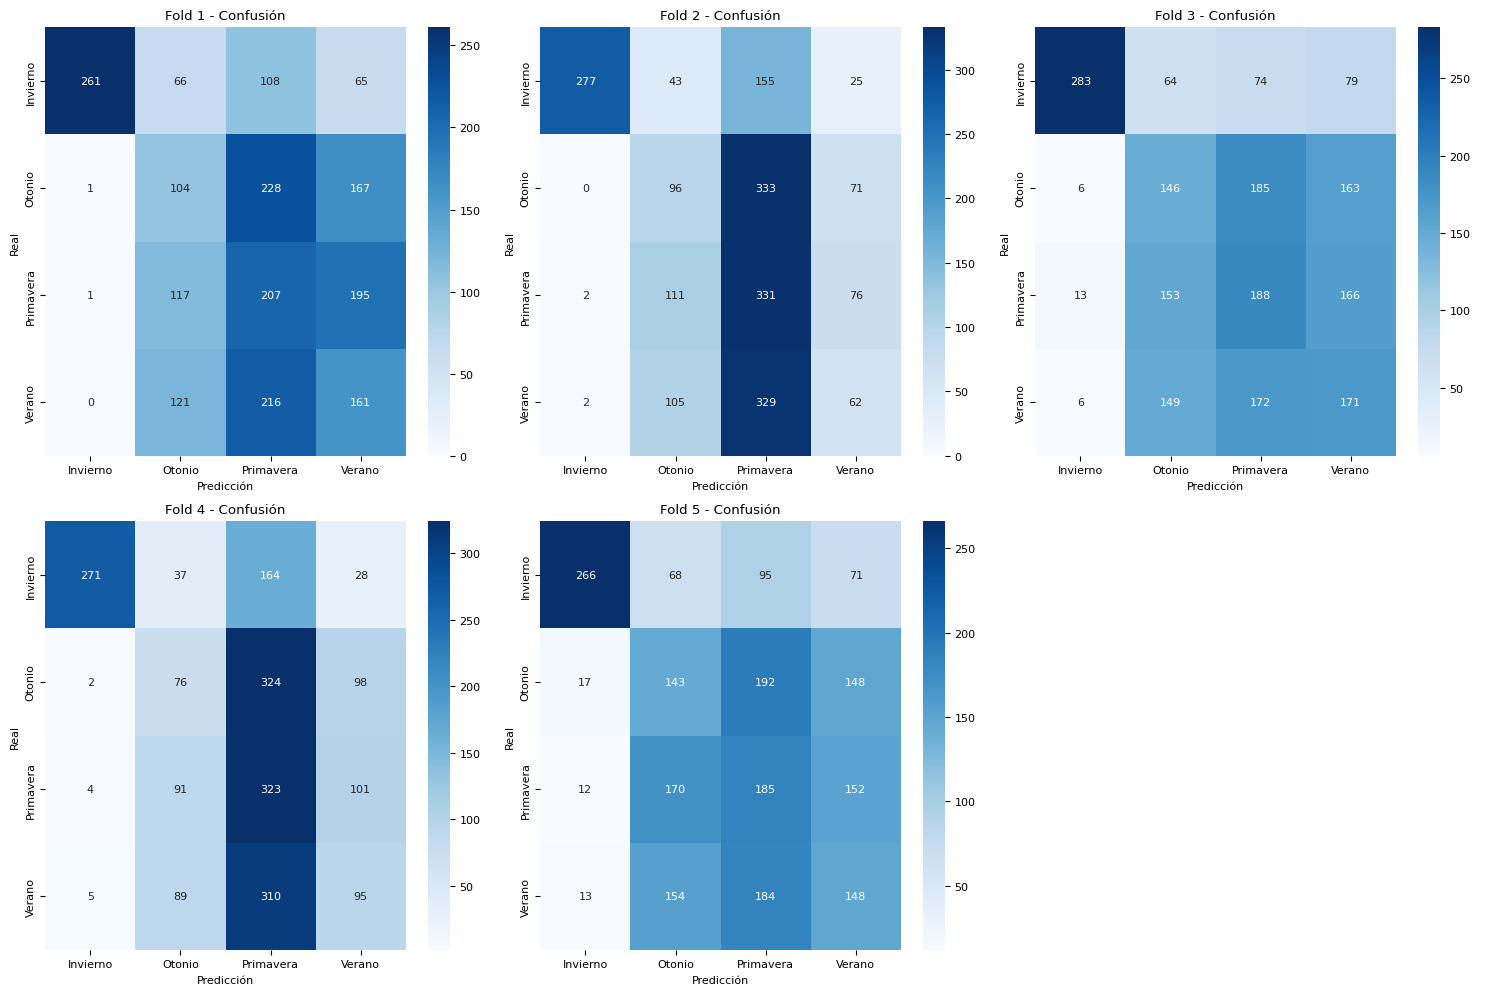


Parámetros finales (moda): {'max_depth': 5, 'n_estimators': 50}

Importancia de las características:
                feature  importance
0           Temperatura      0.4555
4    PresionAtmosferica      0.2191
6     TipoClima_encoded      0.1888
1               Humedad      0.0518
3         Precipitation      0.0434
2       VientoVelocidad      0.0221
5  Localizacion_encoded      0.0194


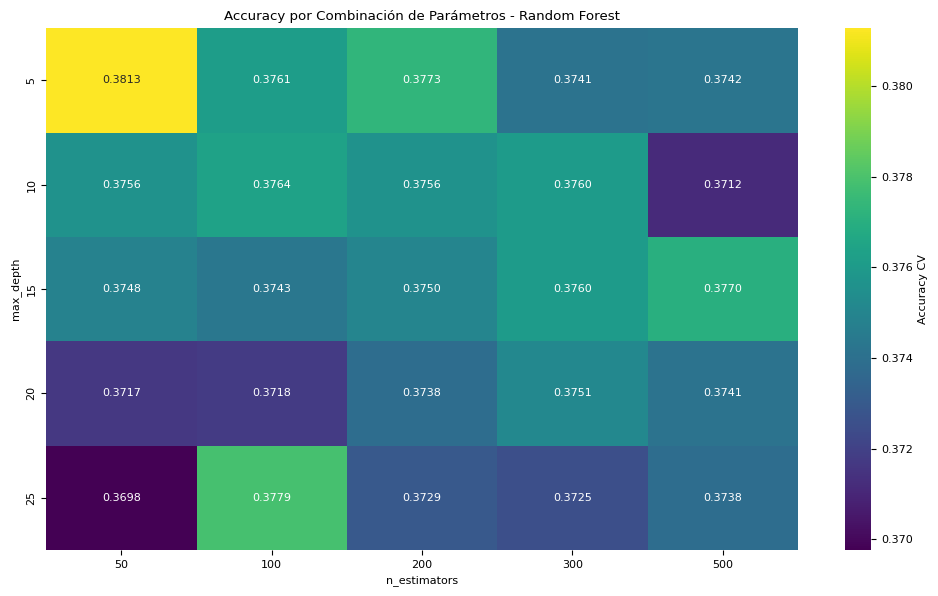

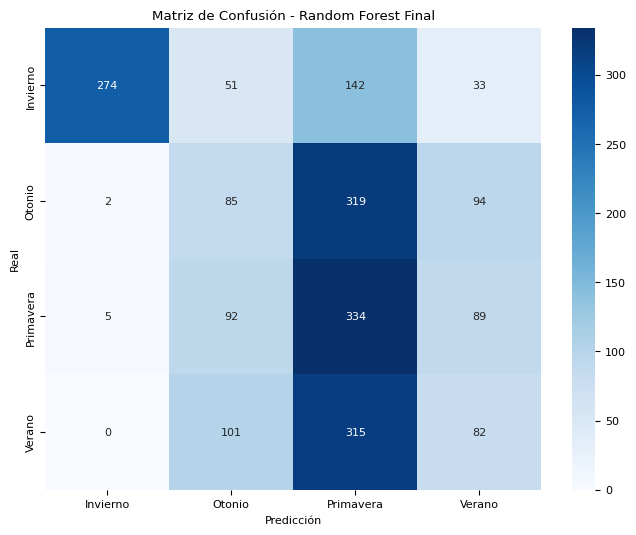

In [10]:
X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0)
y = pd.concat([y_train, y_test], axis=0)

# CV anidada
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20, 25]
}

outer_scores_acc = []
outer_scores_prec = []
outer_scores_rec = []
best_params_list = []
confusion_matrices = []
inner_cv_scores = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_scaled, y)):
    print(f"Fold externo {fold + 1}/5")

    # División del fold externo
    X_train_fold = X_scaled.iloc[train_idx]
    X_test_fold = X_scaled.iloc[test_idx]
    y_train_fold = y.iloc[train_idx]
    y_test_fold = y.iloc[test_idx]

    # Loop interno: optimización de hiperparámetros
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train_fold, y_train_fold)

    # Guardar scores de CV interna
    inner_cv_scores.append({
        'fold': fold + 1,
        'best_score_cv_inner': grid_search.best_score_,
        'best_params': grid_search.best_params_
    })

    # Evaluación en fold externo con mejores parámetros
    best_model = grid_search.best_estimator_
    y_pred_fold = best_model.predict(X_test_fold)

    # Calcular métricas
    acc_fold = accuracy_score(y_test_fold, y_pred_fold)
    prec_fold = precision_score(y_test_fold, y_pred_fold, average='macro')
    rec_fold = recall_score(y_test_fold, y_pred_fold, average='macro')

    # Guardar matriz de confusión
    cm_fold = confusion_matrix(y_test_fold, y_pred_fold)
    confusion_matrices.append(cm_fold)

    outer_scores_acc.append(acc_fold)
    outer_scores_prec.append(prec_fold)
    outer_scores_rec.append(rec_fold)
    best_params_list.append(grid_search.best_params_)

    print(f"  Mejores parámetros: {grid_search.best_params_}")
    print(f"  CV interna score: {grid_search.best_score_:.4f}")
    print(f"  Test externo - Accuracy: {acc_fold:.4f}, Precision: {prec_fold:.4f}, Recall: {rec_fold:.4f}")

# Resultados finales
print(f"\nResultados CV Anidada:")
print(f"Accuracy: {np.mean(outer_scores_acc):.4f} ± {np.std(outer_scores_acc):.4f}")
print(f"Precision: {np.mean(outer_scores_prec):.4f} ± {np.std(outer_scores_prec):.4f}")
print(f"Recall: {np.mean(outer_scores_rec):.4f} ± {np.std(outer_scores_rec):.4f}")

# Mostrar scores de CV interna por fold
print(f"\nScores CV interna por fold:")
inner_df = pd.DataFrame(inner_cv_scores)
print(inner_df)

# Parámetros más frecuentes
params_df = pd.DataFrame(best_params_list)
print(f"\nParámetros seleccionados por fold:")
print(params_df)

# Visualizar matrices de confusión de los 5 folds externos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    axes[i].set_title(f'Fold {i+1} - Confusión')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

# Ocultar subplot vacío
axes[5].axis('off')
plt.tight_layout()
plt.show()

# Entrenar modelo final con parámetros más comunes
final_params_raw = params_df.mode().iloc[0].to_dict()
final_params = {
    'max_depth': None if pd.isna(final_params_raw['max_depth']) or final_params_raw['max_depth'] is None else int(final_params_raw['max_depth']),
    'n_estimators': int(final_params_raw['n_estimators'])
}
print(f"\nParámetros finales (moda): {final_params}")

final_model = RandomForestClassifier(**final_params, random_state=42, n_jobs=-1)
final_model.fit(X_train_scaled, y_train)
y_pred_rf = final_model.predict(X_test_scaled)

# Importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportancia de las características:")
print(feature_importance.round(4))

# Heatmap de accuracy por combinación de parámetros
grid_search_viz = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='accuracy'
)
grid_search_viz.fit(X_scaled, y)

results_viz = pd.DataFrame(grid_search_viz.cv_results_)
accuracy_matrix = results_viz.pivot_table(
    values='mean_test_score',
    index=['param_max_depth'],
    columns=['param_n_estimators']
)

plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_matrix, annot=True, fmt='.4f', cmap='viridis',
            cbar_kws={'label': 'Accuracy CV'})
plt.title('Accuracy por Combinación de Parámetros - Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.tight_layout()
plt.show()

# Matriz de confusión final
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
           xticklabels=sorted(y.unique()),
           yticklabels=sorted(y.unique()))
plt.title(f'Matriz de Confusión - Random Forest Final')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

**Optimización Random Forest con CV Anidada:**

Se implementó CV anidada con n_estimators=[50, 100, 200, 300, 500] y max_depth=[None, 5, 10, 15, 20, 25]. Parámetros óptimos por moda: **max_depth=5, n_estimators=50**.

**Resultados CV Anidada:**
- **Accuracy:** 37.6% ± 0.96% - baja variabilidad entre folds
- **Precision:** 44.5% ± 1.05% - mejora notable vs accuracy
- **Recall:** 37.5% ± 0.95% - consistente con accuracy

**Importancia de Features (cambio significativo):**
1. **Temperatura (0.4555)** - domina completamente el modelo
2. **PresionAtmosferica (0.2191)** - segundo lugar distante
3. **TipoClima_encoded (0.1888)** - feature categórica relevante
4. Humedad (0.0518), Precipitation (0.0434), VientoVelocidad (0.0221)
5. **Localizacion_encoded (0.0194)** - menor impacto

**Variabilidad entre Folds:**
- Fold 3: mejor performance (39.05% accuracy)
- Fold 1: menor performance (36.32% accuracy)
- **Parámetros inconsistentes** por fold: desde max_depth=5 hasta 25

**Matrices de Confusión (5 folds):**
- **Invierno** consistentemente mejor clasificado (261-283 correctas)
- **Confusión sistemática** Otoño-Primavera-Verano en todos los folds
- Patrón estable: modelo struggle con estaciones intermedias

**Heatmap Parámetros:**
- **max_depth=5-15** rango óptimo (~37.6-37.8%)
- **n_estimators** impacto mínimo una vez >100
- Profundidad limitada previene overfitting efectivamente

**Conclusión:**
CV anidada confirma performance real ~37.6%. **Temperatura emergió como feature dominante** (45.5% importancia). Parámetros conservadores óptimos. Clasificación robusta para invierno, desafío persistente en estaciones intermedias por solapamiento climático.

## Comparacion entre los 3 modelos

In [11]:
# Comparar todos los modelos
models_comparison = pd.DataFrame({
    'Modelo': ['SVM Linear', 'SVM RBF', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred),
                accuracy_score(y_test, y_pred_rbf),
                accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred, average='macro'),
                 precision_score(y_test, y_pred_rbf, average='macro'),
                 precision_score(y_test, y_pred_rf, average='macro')],
    'Recall': [recall_score(y_test, y_pred, average='macro'),
              recall_score(y_test, y_pred_rbf, average='macro'),
              recall_score(y_test, y_pred_rf, average='macro')]
})

print("Comparación de rendimiento en test:")
print(models_comparison.round(4))

# Matriz de confusión para el mejor modelo
best_model_idx = models_comparison['Accuracy'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Modelo']

print(f"\nMejor modelo: {best_model_name}")

if best_model_name == 'SVM Linear':
    best_predictions = y_pred
elif best_model_name == 'SVM RBF':
    best_predictions = y_pred_rbf
else:
    best_predictions = y_pred_rf

print("\n" + "="*50)
print("RESUMEN EJECUTIVO:")
print(f"- Mejor modelo: {best_model_name}")
print(f"- Accuracy: {models_comparison.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"- Precision: {models_comparison.loc[best_model_idx, 'Precision']:.4f}")
print(f"- Recall: {models_comparison.loc[best_model_idx, 'Recall']:.4f}")
print("="*50)

Comparación de rendimiento en test:
          Modelo  Accuracy  Precision  Recall
0     SVM Linear    0.3791     0.3197  0.3739
1        SVM RBF    0.3875     0.4619  0.3866
2  Random Forest    0.3840     0.4524  0.3812

Mejor modelo: SVM RBF

RESUMEN EJECUTIVO:
- Mejor modelo: SVM RBF
- Accuracy: 0.3875
- Precision: 0.4619
- Recall: 0.3866


**Comparación de Modelos:**

**SVM RBF** emerge como el mejor modelo:
- **SVM RBF:** Accuracy 38.75%, Precision 46.19%, Recall 38.66%
- **Random Forest:** Accuracy 38.40%, Precision 45.24%, Recall 38.12%
- **SVM Linear:** Accuracy 37.91%, Precision 31.97%, Recall 37.39%

**SVM RBF** lidera con margin estrecho en accuracy (+0.35% vs RF) pero domina en precision (+1% vs RF, +14% vs Linear).

**Conclusión General:**

1. **Rendimiento limitado:** Accuracy ~38% confirma complejidad inherente del problema
2. **Competencia cerrada:** SVM RBF vs Random Forest prácticamente empatados
3. **SVM RBF superior:** Mejor precision con kernel gaussiano para datos no-lineales
4. **Invierno distinguible:** Única estación consistentemente clasificable
5. **Confusión estacional:** Otoño, Primavera, Verano siguen indistinguibles

El dataset meteorológico básico limita la capacidad discriminativa. Variables adicionales (presión barométrica, radiación solar, índices estacionales) podrían mejorar el rendimiento.